In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import faceted as faceted
import xarray as xr
import numpy as np
import scipy

sns.set(font_scale=1.2)
sns.set_palette('hls', 4)
sns.set_style('ticks')

plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "text.latex.preamble": "\n".join([r'\usepackage{amsmath}'])
})         

In [5]:
ds = xr.open_dataset("../data/DNS/plume_centerline.nc")
epsilon = ds.epsilon
l_hat = 1/epsilon
l_hat_function = scipy.interpolate.interp1d(l_hat.z, l_hat.values)

def To_analytical(l):
    Gamma = 6/1000
    g = 9.8
    cp = 1000
    z_t = 15e3 
    z0 = 1e3 
    return (np.exp((z_t-z0)/l) - 1)*(g/cp - Gamma)*(l)

def MTT(z):
    return 31.3*(z+1.1)**(-5/3)

a,b,c,d = [ -2.06190316, -14.70771946,   0.01750799,   0.56364314]

def b_empirical(z):
    return MTT(z) + (a + b*(1 - np.exp(-z/c)))*np.exp(-z/d)

def db_dz_empirical(z):
    return (-(5/3)*31.3*(z+1.1)**(-8/3) 
            -(1/d)*(a + b*(1 - np.exp(-z/c)))*np.exp(-z/d)
            + (b/c)*np.exp(-z/c)*np.exp(-z/d))

def l_empirical(z,R):
        zhat = z/R
        return -R*b_empirical(zhat)/db_dz_empirical(zhat)


In [6]:
Te0 = 290
Gamma = 6/1000
g = 9.81
cp = 1000

def s_e(z): 
    return g*z + cp*(Te0 - Gamma*z) 

def ds_dz(z,s,R):
    return -(s - s_e(z))/l_empirical(z,R)

def event(z,s,R): 
    return s[0] - s_e(z)
event.terminal = True

def LNB_vs_15km(Tanom0, R):
    y0 = [s_e(1e3) + cp*Tanom0]
    z_range=[1e3, 20e3]
    sol = scipy.integrate.solve_ivp(ds_dz, z_range, y0, 
                                    args=([R]), atol=1e-6,
                                    rtol=1e-6,
                                    events=event)
    s = sol.y
    zs = sol.t
    
    return max(zs)-15e3

def To_numerical(R):    
    return scipy.optimize.root_scalar(LNB_vs_15km, x0=100,
                                      bracket=[50, 2e3],
                                      method='brentq',
                                      xtol=1e-6, rtol=1e-6,
                                      args=(R)).root

To_numerical = np.vectorize(To_numerical)

ls = np.linspace(1e3, 100e3, 200)

Tos_analytical = To_analytical(ls)
Rs = ls/5
Tos_numerical = To_numerical(Rs)

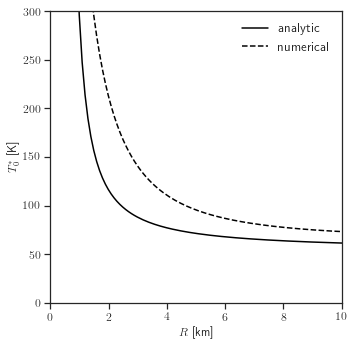

In [7]:
fig, axis = faceted.faceted(1,1, aspect=1.0, width=5.0, left_pad=.7, bottom_pad=.7)

axis[0].plot(Rs/1e3, To_analytical(5*Rs), color='black', 
             label='analytic')

axis[0].plot(Rs/1e3, Tos_numerical, color='black', linestyle='dashed',
             label='numerical')

axis[0].set_ylim([0,300])
axis[0].set_xlim([0,10])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

axis[0].legend(frameon=False)
axis[0].set_ylabel("$T_0^{*} \\text{ [K]}$", fontsize=12)
axis[0].set_xlabel("$R \\text{ [km]}$", fontsize=12)